# Dataset

In [1]:
import torch.cuda
from datasets import list_datasets

all_datasets = list_datasets()
all_datasets[:10]

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews']

In [5]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/eunmi.kim/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
# 데이터타입 확인
emotions["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [9]:
# 데이터 확인
emotions["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [12]:
emotions["train"][:3]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong'],
 'label': [0, 0, 3]}

In [18]:
# 원하는 데이터셋 로드
my_datasets = load_dataset("csv", data_files="data/test.csv")
my_datasets["train"][0]

Found cached dataset csv (/Users/eunmi.kim/.cache/huggingface/datasets/csv/default-7f04c8a38379388b/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

{'text': 'I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily. But then one day a tragic happenstance occurred. After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow. Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel. But then why not just get up and walk across the country to watch TV in another state? "Nuts to that", I said. So I decided to just hang tight on the couch and take whatever Fate had in store for me. What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with nothing whatsoever to back my opinions up with, and once again I was completely right! This show is a total crud-pie! Belushi has all the comedic delivery of a hair

In [30]:
import pandas

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [31]:
df["label_name"] = df["label"].apply(lambda row : emotions["train"].features["label"].int2str(row))
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 클래스 분포
* 샘플링 기법 : imbalanced-lean 라이브러리

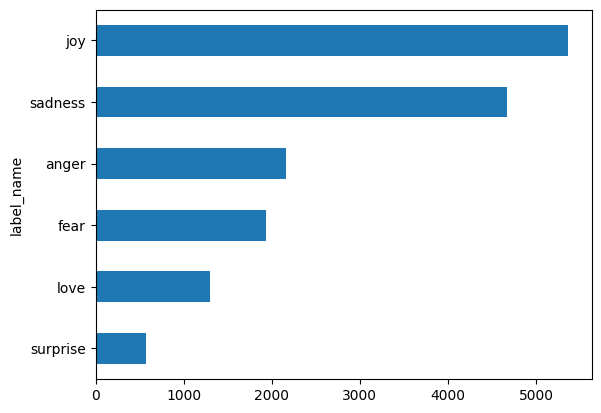

In [32]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.show()

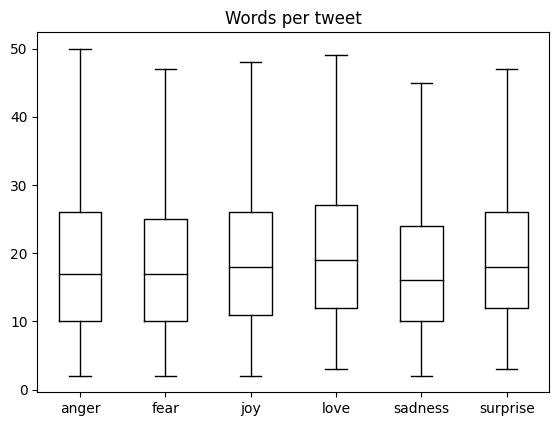

In [33]:
df["Words per tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [34]:
emotions.reset_format()

# 토크나이저

In [37]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
encoded_text = tokenizer("Tokenizing text is a score task of NLP")
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 3556, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [38]:
tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'score',
 'task',
 'of',
 'nl',
 '##p',
 '[SEP]']

* CLS, SEP : 시작과 끝
* #는 앞의 문자열이 공백이 아님을 뜻함

In [43]:
tokenizer(emotions["train"][:2]["text"], padding=True, truncation=True)

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

### 사전 훈련된 모델 사용하기
* AutoModel.from_pretrained : 사전 훈련된 모델의 가중치를 로드함

In [48]:
import torch
from transformers import AutoModel

deviceName = "mps" if torch.backends.mps.is_available() else "cpu"
#deviceName = "cuda" if torch.cuda.is_available() else "cpu"
print(deviceName)
device = torch.device(deviceName)
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

mps


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 은닉 상태 추출하기

In [49]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [51]:
inputs = {k: v.to(device) for k,v in inputs.items()}
print(inputs)

with torch.no_grad() : # 그레이디언트 자동 계산 비활성화
    outputs = model(**inputs)
print(outputs)

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='mps:0')}
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='mps:0'), hidden_states=None, attentions=None)


In [54]:
outputs.last_hidden_state[:,0].size() # 마지막 은닉 상태

torch.Size([1, 768])

In [56]:
def extract_hidden_states(batch) :
    # 모델 입력을 GPU로 옮김
    inputs = { k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names }
    with torch.no_grad() :
        # 은닉 상태 추출
        last_hidden_state = model(**inputs).last_hidden_state

    # [CLS] 토큰에 대한 벡터 반환
    return {"hidden_state" : last_hidden_state[:,0].cpu().numpy()}

In [60]:
emotions_encoded = emotions.map(lambda x : tokenizer(x["text"], padding=True, truncation=True), batched=True, batch_size=None)
emotions_encoded

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/eunmi.kim/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-056557b33d2414f4.arrow
Loading cached processed dataset at /Users/eunmi.kim/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-aec105903431ef9a.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [64]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [63]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

### 특성 행렬 만들기

In [62]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### 훈련 세트 시각화

In [66]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)


SystemError: initialization of _internal failed without raising an exception